#1. Connect to GDrive

In [10]:
#from google.colab import drive
#drive.mount('/content/drive')

In [11]:
#cd "/content/drive/MyDrive/DRL_Project"

# 2. Imports

In [12]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

# for clearing cell output for prints
from IPython.display import clear_output

# 3. Define Time matrix

In [13]:
# Loading the time matrix which acts as traffic data to help calculate time taken to travel between two locations
Time_matrix = np.load("TM.npy")

# 4. Define DQN Agent

In [14]:
class DQNAgent:
    def __init__(self, state_size, action_size, architecture="arch1"):
        """Initialize the DQN Agent with hyperparameters and models."""
        self.state_size = state_size
        self.action_size = action_size
        self.architecture = architecture

        # DQN hyperparameters
        self.discount_factor = 0.95
        self.learning_rate = 0.001
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003
        self.epsilon_min = 1e-8
        self.batch_size = 32

        # Replay memory
        self.memory = deque(maxlen=2000)

        # Neural network model
        self.model = self._build_model()

    def _build_model(self):
        """Build the neural network for Q-value approximation."""
        model = Sequential()
        if self.architecture == "arch1":
            model.add(Dense(units=200, input_dim=self.state_size, activation='relu', name="DHLayer-1"))
            model.add(Dense(units=150, activation='relu', name="DHLayer-2"))
            model.add(Dense(units=100, activation='relu', name="DHLayer-3"))
            model.add(Dense(units=1, activation='linear', name="Output"))
        elif self.architecture == "arch2":
            model.add(Dense(200, input_dim=self.state_size, activation='relu', name="HiddenLayer1"))
            model.add(Dense(150, activation='relu', name="HiddenLayer2"))
            model.add(Dense(100, activation='relu', name="HiddenLayer3"))
            model.add(Dense(self.action_size, activation='linear', name="OutputLayer"))
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        print(model.summary())
        return model

    def _epsilon_decay(self, episode):
        """Calculate epsilon value based on decay schedule."""
        return self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay * episode)

    def get_action(self, state, episode):
        """Choose an action using an epsilon-greedy policy."""
        epsilon = self._epsilon_decay(episode)
        possible_actions_idx, possible_actions = env.requests(state)

        if random.random() > epsilon:
            # Exploitation
            if self.architecture == "arch1":
                q_values = self.prediction(state, possible_actions)
                best_action_idx = np.argmax(q_values)
                action = possible_actions[best_action_idx]
            elif self.architecture == "arch2":
                state_encoded = np.reshape(env.state_encod_arch_2(state), [1, self.state_size])
                q_values = self.model.predict(state_encoded, verbose=0)
                best_action_idx = np.argmax(q_values[0][possible_actions_idx])
                action = possible_actions[best_action_idx]
        else:
            # Exploration
            action = random.choice(possible_actions)

        return action, epsilon

    def prediction(self, state, actions=None):
        """
        Predict Q-values for a given state. Supports both Arch1 and Arch2.

        Parameters:
        - state: The current state.
        - actions: A list of actions (required for Arch1 only).

        Returns:
        - Q-values for the provided state and actions (Arch1) or all actions (Arch2).
        """
        if self.architecture == "arch1":
            # Arch1: Predict Q-values for state-action pairs
            assert actions is not None, "Actions must be provided for Arch1."
            X_test = np.zeros((len(actions), self.state_size))
            for i, action in enumerate(actions):
                X_test[i, :] = env.state_encod_arch1(state, action)
            predictions = self.model.predict(X_test, verbose=0).reshape(len(actions))
        elif self.architecture == "arch2":
            # Arch2: Predict Q-values for the state only
            state_encoded = env.state_encod_arch_2(state).reshape(1, -1)
            predictions = self.model.predict(state_encoded, verbose=0)[0]
        return predictions


    def store_experience(self, state, action, reward, next_state, is_terminal):
        """Store the experience tuple in replay memory."""
        self.memory.append((state, action, reward, next_state, is_terminal))

    def train_model(self):
        """Train the model using a batch of experiences."""
        if len(self.memory) < self.batch_size:
            return

        mini_batch = random.sample(self.memory, self.batch_size)

        if self.architecture == "arch1":
            # For Arch1: State-action pair encoding
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
        elif self.architecture == "arch2":
            # For Arch2: State-only encoding
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))

        actions, rewards, terminals = [], [], []

        for i, (state, action, reward, next_state, terminal) in enumerate(mini_batch):
            actions.append(env.action_space.index(action))
            rewards.append(reward)
            terminals.append(terminal)

            if self.architecture == "arch1":
                update_input[i] = env.state_encod_arch1(state, action)
                update_output[i] = env.state_encod_arch1(next_state, action)
            elif self.architecture == "arch2":
                update_input[i] = env.state_encod_arch_2(state)
                update_output[i] = env.state_encod_arch_2(next_state)

        # Predict Q-values
        target = self.model.predict(update_input, verbose=0)
        target_next = self.model.predict(update_output, verbose=0)

        for i in range(self.batch_size):
          if self.architecture == "arch1":
            # For Arch1: Only one Q-value is predicted
            if terminals[i]:
              target[i] = rewards[i]
            else:
              target[i] = rewards[i] + self.discount_factor * np.max(target_next[i])
          elif self.architecture == "arch2":
            # For Arch2: Multiple Q-values are predicted
            if terminals[i]:
               target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_next[i])


        # Train the model
        self.model.fit(update_input, target, epochs=1, batch_size=self.batch_size, verbose=0)

    def save_model(self, filepath):
        """Save model weights to a file."""
        self.model.save_weights(filepath)

    def load_model(self, filepath):
        """Load model weights from a file."""
        self.model.load_weights(filepath)

# 5. Train and Evaluate Agent

In [15]:
states_to_track=dict()
# Function to save the Q-dictionary and objects as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def initialise_tracking_states():
    random_states = random.sample(env.state_space,5)   # 5 Random State from State space
    random_actions = random.sample(env.action_space,5) # 5 Random Actions from State space
    for i in range(5):
        states_to_track[random_states[i]]={random_actions[i]:[]} # Join together, We will Append Predicted Q Values here.

def save_tracking_states(agent):
    for state in states_to_track.keys():
        for action in states_to_track[state].keys():
            state_encd = env.state_encod_arch_2(state)                     # Encode State
            state_encd = np.reshape(state_encd, [1, agent.state_size])     # Reshape 1 X State_size
            predicted_q_values=agent.model.predict(state_encd,verbose=0)   # Predict Q Values for all Actions for current State
            action_index = env.action_space.index(action)                  # Get index of tracked action
            q_value = predicted_q_values[0][action_index]                  # Get Q Value for tracked action
            states_to_track[state][action].append(q_value)                 # Append Q Value for tracked state action pair


In [16]:
env = CabDriver()                 # Initalise environment
# agent = DQNAgent()                # Initalise Agent
agent_arch2 = DQNAgent(state_size=env.state_size_arch_2, action_size=env.action_size, architecture="arch2")

initialise_tracking_states()      #  Initalise tracking states ( to be done after env since it uses state and action space from env )

#Initalise empty list to help tracking and graphing
avg_rewards = []
total_rewards = []
avg_epsilon = []

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ HiddenLayer1 (Dense)            │ (None, 200)            │         7,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer2 (Dense)            │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer3 (Dense)            │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 21)             │         2,121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,771 (213.95 KB)

 Trainable params: 54,771 (213.95 KB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
import matplotlib.pyplot as plt
import csv
import os


def train_dqn_agent(agent, env, Time_matrix, Episodes, reward_threshold):
    """
    Train the DQN agent, track metrics, and calculate success rate.

    Parameters:
    - agent: The DQNAgent instance.
    - env: The environment instance.
    - Time_matrix: Time matrix for travel between locations.
    - Episodes: Total number of episodes to train.
    - reward_threshold: The reward value that defines success for an episode.

    Returns:
    - success_rate: Final success rate.
    - avg_rewards: List of average rewards per episode.
    - total_rewards: List of total rewards per episode.
    - avg_epsilon: List of average epsilon values per episode.
    """
    log_file_path = "training_metrics_log_" + agent.architecture + ".csv"
    file_exists = os.path.isfile(log_file_path)
    success_count = 0  # Count of successful episodes
    avg_rewards, total_rewards, avg_epsilon = [], [], []  # Initialize tracking lists
    with open(log_file_path, mode='a', newline='') as log_file:
      log_writer = csv.writer(log_file)
      if not file_exists:
        log_writer.writerow(['Episode', 'Total Reward', 'Average Reward', 'Average Epsilon', 'Success Rate'])

      for episode in range(Episodes):
          _, _, state = env.reset()  # Reset environment and fetch initial state
          total_reward = 0
          trip_count = 0
          total_epsilon = 0
          terminal_state = False

          while not terminal_state:
              action, epsilon = agent.get_action(state, episode)  # Get action using epsilon-greedy policy
              reward = env.reward_func(state, action, Time_matrix)  # Calculate reward
              next_state, terminal_state = env.next_state_func(state, action, Time_matrix)  # Get next state
              agent.store_experience(state, action, reward, next_state, terminal_state)  # Store experience
              total_reward += reward  # Update total reward
              total_epsilon += epsilon  # Update total epsilon
              trip_count += 1  # Update trip count
              state = next_state  # Move to next state
              clear_output(wait=True)
          # Train the agent after the episode ends
          agent.train_model()

          # Update tracking metrics
          avg_reward = total_reward / trip_count if trip_count > 0 else 0
          avg_epsilon_value = total_epsilon / trip_count if trip_count > 0 else 0

          total_rewards.append(total_reward)
          avg_rewards.append(avg_reward)
          avg_epsilon.append(avg_epsilon_value)

          # Track success rate
          if total_reward >= reward_threshold:
              success_count += 1

          success_rate = success_count / (episode + 1)

          # Logging progress
          if episode % 2 == 0 or episode == Episodes - 1:
            log_writer.writerow([episode, total_reward, avg_reward, avg_epsilon_value, success_rate])

          print(f"Episode: {episode}, Total Reward: {total_reward:.2f}, Avg Reward: {avg_reward:.2f}, "
                f"Avg Epsilon: {avg_epsilon_value:.5f}, Success Rate: {success_rate * 100:.2f}%")

          # Plot metrics periodically
          if episode % 100 == 0 and episode > 0:
              plot_metrics(avg_rewards, total_rewards, avg_epsilon)


    # Final output
    agent.save_model(f"./dqn_agent_weights_final_{agent.architecture}.weights.h5")
    print(f"Final Success Rate: {success_rate * 100:.2f}%")
    return success_rate, avg_rewards, total_rewards, avg_epsilon


def plot_metrics(avg_rewards, total_rewards, avg_epsilon):
    """
    Plot the metrics for tracking agent's performance during training.

    Parameters:
    - avg_rewards: List of average rewards per episode.
    - total_rewards: List of total rewards per episode.
    - avg_epsilon: List of average epsilon values per episode.
    """
    plt.figure(figsize=(15, 5))

    # Average Rewards
    plt.subplot(1, 3, 1)
    plt.plot(avg_rewards, label="Avg Reward")
    plt.title('Average Reward per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()

    # Total Rewards
    plt.subplot(1, 3, 2)
    plt.plot(total_rewards, label="Total Reward")
    plt.title('Total Reward per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()

    # Average Epsilon
    plt.subplot(1, 3, 3)
    plt.plot(avg_epsilon, label="Avg Epsilon")
    plt.title('Average Epsilon per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Epsilon')
    plt.legend()

    plt.tight_layout()
    plt.show()


##5.1 Architecture 2

In [18]:
# agent_arch1 = DQNAgent(state_size=env.state_size_arch_1, action_size=env.action_size, architecture="arch1")
success_rate, avg_rewards, total_rewards, avg_epsilon = train_dqn_agent(agent_arch2, env, Time_matrix, Episodes=10000, reward_threshold=100)
arch2_avg_rewards, arch2_total_rewards, arch2_avg_epsilon = avg_rewards, total_rewards, avg_epsilon

Episode: 9999, Total Reward: 1006.00, Avg Reward: 4.91, Avg Epsilon: 0.04980, Success Rate: 90.38%
Final Success Rate: 90.38%


###5.1.1 Plot

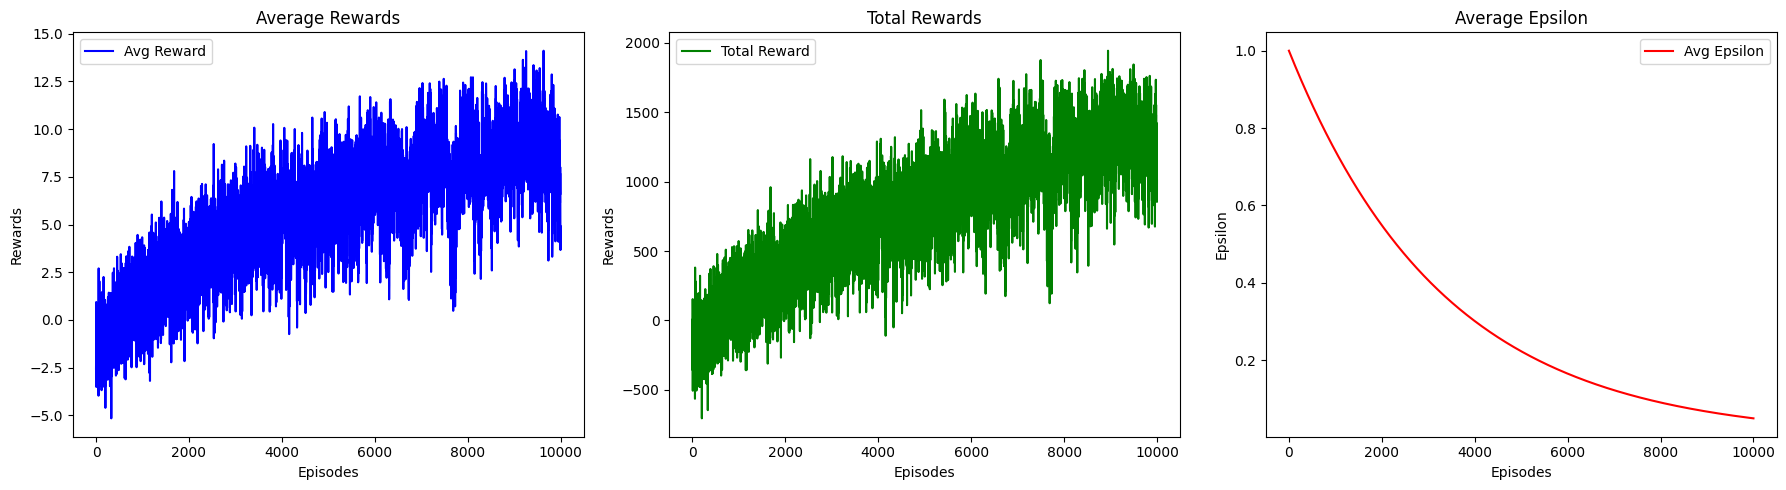

In [19]:
import matplotlib.pyplot as plt

# Ensure you have the data lists: arch2_avg_rewards, arch2_total_rewards, arch2_avg_epsilon

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot Average Rewards
axs[0].plot(range(len(arch2_avg_rewards)), arch2_avg_rewards, label='Avg Reward', color='b')
axs[0].set_title('Average Rewards')
axs[0].set_xlabel('Episodes')
axs[0].set_ylabel('Rewards')
axs[0].legend()

# Plot Total Rewards
axs[1].plot(range(len(arch2_total_rewards)), arch2_total_rewards, label='Total Reward', color='g')
axs[1].set_title('Total Rewards')
axs[1].set_xlabel('Episodes')
axs[1].set_ylabel('Rewards')
axs[1].legend()

# Plot Average Epsilon
axs[2].plot(range(len(arch2_avg_epsilon)), arch2_avg_epsilon, label='Avg Epsilon', color='r')
axs[2].set_title('Average Epsilon')
axs[2].set_xlabel('Episodes')
axs[2].set_ylabel('Epsilon')
axs[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


## 5.2. Architecture 1

In [20]:
agent_arch1 = DQNAgent(state_size=env.state_size_arch_1, action_size=env.action_size, architecture="arch1")
initialise_tracking_states()      #  Initalise tracking states ( to be done after env since it uses state and action space from env )
#Initalise empty list to help tracking and graphing
avg_rewards = []
total_rewards = []
avg_epsilon = []


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ DHLayer-1 (Dense)               │ (None, 200)            │         9,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DHLayer-2 (Dense)               │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DHLayer-3 (Dense)               │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,751 (213.87 KB)

 Trainable params: 54,751 (213.87 KB)

 Non-trainable params: 0 (0.00 B)

None


In [21]:
success_rate, avg_rewards, total_rewards, avg_epsilon = train_dqn_agent(
    agent_arch1, env, Time_matrix, Episodes=2500, reward_threshold=100)

arch1_avg_rewards, arch1_total_rewards, arch1_avg_epsilon = avg_rewards, total_rewards, avg_epsilon

Episode: 2499, Total Reward: 381.00, Avg Reward: 2.52, Avg Epsilon: 0.47251, Success Rate: 46.00%
Final Success Rate: 46.00%


###5.2.1

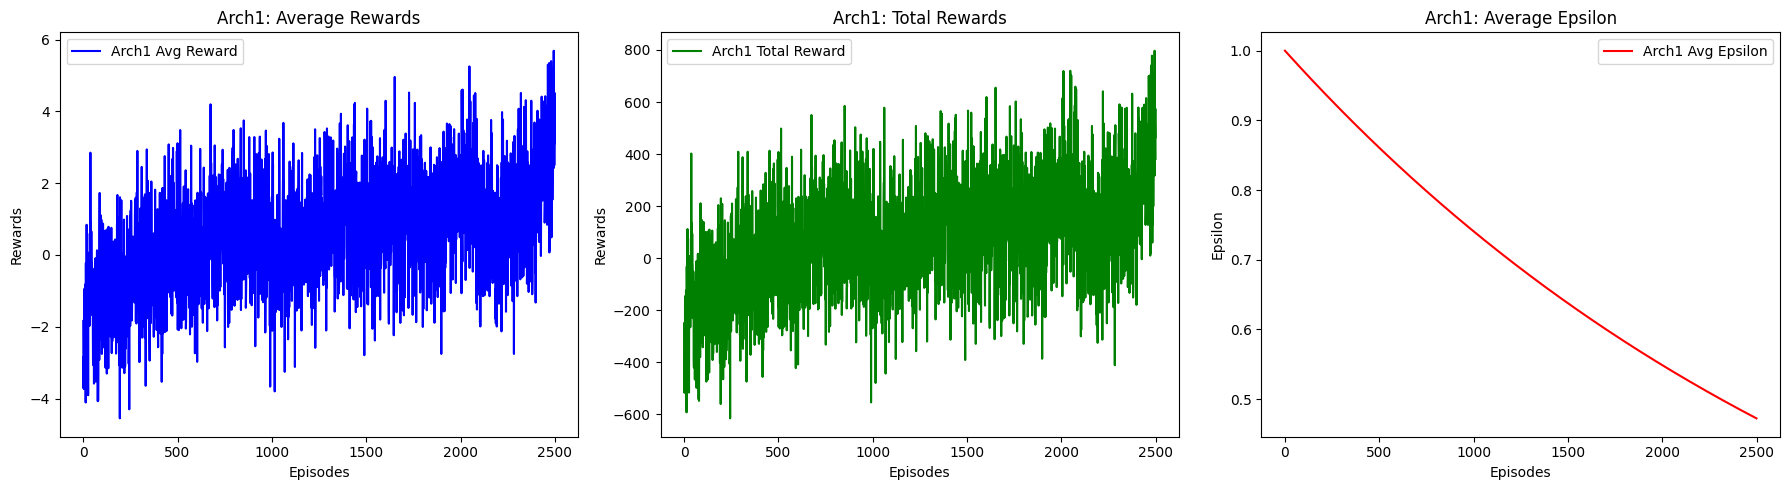

In [22]:
# Create a figure and a set of subplots for Arch1
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot Average Rewards for Arch1
axs[0].plot(range(len(arch1_avg_rewards)), arch1_avg_rewards, label='Arch1 Avg Reward', color='b')
axs[0].set_title('Arch1: Average Rewards')
axs[0].set_xlabel('Episodes')
axs[0].set_ylabel('Rewards')
axs[0].legend()

# Plot Total Rewards for Arch1
axs[1].plot(range(len(arch1_total_rewards)), arch1_total_rewards, label='Arch1 Total Reward', color='g')
axs[1].set_title('Arch1: Total Rewards')
axs[1].set_xlabel('Episodes')
axs[1].set_ylabel('Rewards')
axs[1].legend()

# Plot Average Epsilon for Arch1
axs[2].plot(range(len(arch1_avg_epsilon)), arch1_avg_epsilon, label='Arch1 Avg Epsilon', color='r')
axs[2].set_title('Arch1: Average Epsilon')
axs[2].set_xlabel('Episodes')
axs[2].set_ylabel('Epsilon')
axs[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots for Arch1
plt.show()

#6. Policy gradient

In [24]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import random

class PolicyGradientAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma  # Discount factor for rewards

        self.model = self.build_model()
        self.episode_memory = []  # Stores (state, action, reward) tuples

    def build_model(self):
        # Build the neural network model for policy gradient
        model = Sequential()
        model.add(Dense(units=200, input_dim=self.state_size, activation='relu'))
        model.add(Dense(units=150, activation='relu'))
        model.add(Dense(units=self.action_size, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=self.learning_rate))

        print("Model Summary:")
        print(model.summary())  # Debugging: Print model architecture

        return model

    def choose_action(self, state):
        state = np.array(state)
        state = np.reshape(state, (1, self.state_size))  # Reshape state for model input

        # Predict action probabilities
        action_probs = self.model.predict(state, verbose=0)

        # Flatten action_probs to 1D
        action_probs = np.squeeze(action_probs)

        if action_probs.shape[0] != self.action_size:
            raise ValueError(f"Expected action_probs to have length {self.action_size}, got {action_probs.shape[0]}")

        # Choose action based on probabilities
        action = np.random.choice(self.action_size, p=action_probs)
        return action

    def store_transition(self, state, action, reward):
        self.episode_memory.append((state, action, reward))

    def train(self):
        # Compute discounted rewards
        discounted_rewards = np.zeros(len(self.episode_memory))
        cumulative = 0
        for t in reversed(range(len(self.episode_memory))):
            cumulative = cumulative * self.gamma + self.episode_memory[t][2]
            discounted_rewards[t] = cumulative

        # Normalize rewards
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards) + 1e-8  # Prevent division by zero

        # Prepare training data
        X = np.vstack([e[0] for e in self.episode_memory])
        y = np.zeros([len(self.episode_memory), self.action_size])

        for idx, (state, action, reward) in enumerate(self.episode_memory):
            y[idx][action] = discounted_rewards[idx]  # Assign discounted reward to the taken action

        # Train the model
        self.model.train_on_batch(X, y)
        self.episode_memory = []  # Clear memory after training

    def load(self, name):
        # Load model weights from file
        try:
            self.model.load_weights(name)
            print(f"Model weights loaded from {name}")
        except Exception as e:
            print(f"Error loading model weights: {e}")

    def save(self, name):
        # Save model weights to file
        try:
            self.model.save_weights(name)
            print(f"Model weights saved to {name}")
        except Exception as e:
            print(f"Error saving model weights: {e}")


# Define environment and agent
class CabDriver:
    def __init__(self):
        self.state_size = 3  # Example state size, replace with actual
        self.action_size = 3  # Example action size, replace with actual
        self.time_matrix = np.random.rand(3, 3)  # Replace with actual time matrix
        self.state = np.zeros(self.state_size)  # Initial state (example)
        self.steps_taken = 0  # Track steps taken for episode

    def reset(self):
        self.state = np.random.rand(self.state_size)  # Reset to random state or actual reset logic
        self.steps_taken = 0  # Reset steps
        #print(f"State reset: {self.state}")  # Debug print
        return self.state

    def next_state_func(self, state, action, Time_matrix):
        # Simulate next state based on action and state; adjust as necessary
        next_state = state + np.random.randn(self.state_size)  # Example: random change in state
        self.steps_taken += 1

        # For example, terminate when the state exceeds a threshold or after max steps
        terminal_state = False
        if np.sum(next_state) > 5.0:  # Threshold for termination (example)
            terminal_state = True
        elif self.steps_taken > 10:  # Max steps condition (example)
            terminal_state = True

        #print(f"State: {state} -> Next state: {next_state} | Steps taken: {self.steps_taken} | Done: {terminal_state}")
        return next_state, terminal_state

    def reward_func(self, state, action, Time_matrix):
        # Simulate a reward function; replace with actual logic
        reward = np.random.rand()  # Example: random reward
        return reward


# Training loop
env = CabDriver()  # Initialize the environment
agent = PolicyGradientAgent(state_size=env.state_size, action_size=env.action_size)
episodes = 2500
log_file_path = 'pg_training_metrics_log.csv'
file_exists = os.path.isfile(log_file_path)

with open(log_file_path, mode='a', newline='') as log_file:
  log_writer = csv.writer(log_file)
  for episode in range(episodes):
      state = env.reset()  # Reset the environment and get initial state
      episode_reward = 0
      done = False
      trip_count = 0
      avg_reward = 0

      while not done:
          action = agent.choose_action(state)  # Choose an action using the policy

          # Simulate the environment step
          next_state, done = env.next_state_func(state, action, env.time_matrix)
          reward = env.reward_func(state, action, env.time_matrix)

          # Store the transition
          agent.store_transition(state, action, reward)

          # Update state for the next step
          state = next_state
          episode_reward += reward
          trip_count += 1

          #print(f"Episode {episode} Step Reward: {reward} | Total Reward: {episode_reward}")

      # Train the agent after each episode
      agent.train()
      avg_rewards = episode_reward/trip_count if trip_count > 0 else 0
      success_rate = 1 if episode_reward >= 100 else 0

      if episode % 200 == 0 or episode == episodes - 1:
            log_writer.writerow([episode, episode_reward, success_rate, avg_reward])
            # Log or plot rewards here for monitoring
            print(f"Episode {episode} completed. Total reward: {episode_reward}, Avg reward: {avg_reward}")

  # Save model weights periodically
  agent.save("policy_gradient.weights.h5")




Model Summary:


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 200)            │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,403 (122.67 KB)

 Trainable params: 31,403 (122.67 KB)

 Non-trainable params: 0 (0.00 B)

None
Episode 0 completed. Total reward: 2.4367052143256016, Avg reward: 0
Episode 200 completed. Total reward: 6.00459503422605, Avg reward: 0
Episode 400 completed. Total reward: 4.931354310681859, Avg reward: 0
Episode 600 completed. Total reward: 4.264534401479046, Avg reward: 0
Episode 800 completed. Total reward: 2.703005537009695, Avg reward: 0
Episode 1000 completed. Total reward: 5.484130312648864, Avg reward: 0
Episode 1200 completed. Total reward: 5.952648746264363, Avg reward: 0
Episode 1400 completed. Total reward: 3.8030731748447035, Avg reward: 0
Episode 1600 completed. Total reward: 4.778118610469666, Avg reward: 0
Episode 1800 completed. Total reward: 4.757352843699293, Avg reward: 0
Episode 2000 completed. Total reward: 6.425620103848841, Avg reward: 0
Episode 2200 completed. Total reward: 1.949058578264931, Avg reward: 0
Episode 2400 completed. Total reward: 5.684491423098136, Avg reward: 0
Episode 2499 completed. Total reward: 5.354297939778505, Avg reward: 0
Model w